* Master DAC - BDLE
* Author: Mohamed-Amine Baazizi
* Affiliation: LIP6 - Faculté des Sciences - Sorbonne Université
* Email: mohamed-amine.baazizi@lip6.fr
* October 2023


# Querying nested data

This lab session complements the previous session with several concepts:
* manipulating irregular, nested data represented in JSON format
* using windowing functions, multi-dimensional aggregations, and pivot tables

## Pre-requisite

In [2]:
!pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
!pip install --upgrade -q pyspark==3.4
!pip install --upgrade -q delta-spark==2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession

local = "local[*]"
appName = "Spark-Dataframe-JSON"
localConfig = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory")

spark = SparkSession.builder.config(conf = localConfig).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

### Data loading

In [5]:
! mkdir -p /tmp/spark-dataframe/

In [6]:
! wget https://nuage.lip6.fr/s/3CFYf9qFNitKKER/download/vk_001.json.zip -O /tmp/spark-dataframe/vk_001.json.zip

--2023-10-25 23:16:42--  https://nuage.lip6.fr/s/3CFYf9qFNitKKER/download/vk_001.json.zip
Resolving nuage.lip6.fr (nuage.lip6.fr)... 132.227.201.11
Connecting to nuage.lip6.fr (nuage.lip6.fr)|132.227.201.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15376718 (15M) [application/zip]
Saving to: ‘/tmp/spark-dataframe/vk_001.json.zip’

/tmp/spark-datafram 100%[===================>]  14.66M  5.01MB/s    in 2.9s    

2023-10-25 23:16:46 (5.01 MB/s) - ‘/tmp/spark-dataframe/vk_001.json.zip’ saved [15376718/15376718]



In [7]:
! unzip /tmp/spark-dataframe/vk_001.json.zip -d /tmp/spark-dataframe/

Archive:  /tmp/spark-dataframe/vk_001.json.zip
  inflating: /tmp/spark-dataframe/vk_001.json  


In [8]:
path = '/tmp/spark-dataframe/'

## Dataset loading
The dataset used in this lab session describes posts exchanged in a Russian social network, called VK, during the 2018 Russian elections.
The schema of this dataset is described in the official API website
https://vk.com/dev/streaming_api_docs_2?f=7.%2BЧтение%2Bпотока


We will use this dataset to perform some analytics on the type of posts, the tags used in these post and the relationships between authors of the posts.

In [9]:
data = spark.read.format("json").load(path+'/vk_001.json').distinct()
data.count()

30683

In [10]:
#examine the schema
data.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- code: long (nullable = true)
 |-- event: struct (nullable = true)
 |    |-- action: string (nullable = true)
 |    |-- attachments: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- album: struct (nullable = true)
 |    |    |    |    |-- created: long (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- id: string (nullable = true)
 |    |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |    |-- size: long (nullable = true)
 |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |-- access_key: string (nullable = true)
 |    |    |    |    |    |-- album_id: long (nullable = true)
 |    |    |    |    |    |-- date: long (nullable = true)
 |    |    |    |    |    |-- height: long (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 | 

## Questions

The schema indicates each attribute with nullable=true which is not very informative since we can not know whether a field has missing values.
The following instructions count the number of rows w/o missing values for some specific fields of interest.

In [11]:
att_list = ["event",
                 "event.event_id",
                 "event.event_id.post_id",
                 "event.event_id.post_owner_id",
                 "event.event_id.comment_id",
                 "event.event_id.shared_post_id",
                 "event.author",
                 "event.attachments",
                 "event.geo",
                 "event.tags",
                 "event.creation_time"]

In [12]:
print("Total number of data:", data.count())

Total number of data: 30683


In [13]:
for att in att_list:
    print("count of %s=%s"%(att, data.where(att+ " is not null").count()))

count of event=30683
count of event.event_id=30683
count of event.event_id.post_id=30683
count of event.event_id.post_owner_id=30683
count of event.event_id.comment_id=16518
count of event.event_id.shared_post_id=638
count of event.author=30683
count of event.attachments=15944
count of event.geo=22
count of event.tags=30683
count of event.creation_time=30683


Comme le nombre de données est de 30683, nous en déduisons que les champs ayant moins de lignes que cette valeur contiennent des missing values.
En locurence:
- event.event_id.comment_id
- event.event_id.shared_post_id
- event.attachments
- event.geo

What do you observe? Which attributes have missing values?

Feel free to examine the content of these attributes (count the number of distinct values, examine a sample of distinct values, etc)

The official documentation (https://vk.com/dev/streaming_api_docs_2?f=7.%2BЧтение%2Bпотока) reports on some assumptions about the presence/absence of values.
For example, the field `event.event_id.comment_id` is present only when `event.event_type='comment'` and `event.event_id.shared_post_id` is present only when `event.event_type='share'`.

Write two queries to verify these assumptions.

#### Check that `event.event_id.comment_id` is present only when `event.event_type='comment'`

In [14]:
# data.#complete

n1 = data.where("event.event_id.comment_id is not null").count()
n2 = data.where("event.event_type='comment' ").count()

print(n1, n2, n1 == n2)

16518 16518 True


#### Check that `event.event_id.shared_post_id` is present only when `event.event_type='share'`

In [15]:
# data.#complete

n1 = data.where("event.event_id.shared_post_id is not null").count()
n2 = data.where("event.event_type='share' ").count()

print(n1, n2, n1 == n2)

638 638 True


#### How many distinct post ids are there?

In [16]:
from pyspark.sql.functions import count, countDistinct

In [17]:
nb_posts = data\
.agg(countDistinct("event.event_id.post_id").alias("nb_distinct_posts"))
nb_posts.show()

+-----------------+
|nb_distinct_posts|
+-----------------+
|            21683|
+-----------------+



#### How many distinct post_ids per event type

In [18]:
post_per_type = data\
.groupBy('event.event_type').agg(countDistinct("event.event_id.post_id").alias("count_objects"))
post_per_type.show()

+----------+-------------+
|event_type|count_objects|
+----------+-------------+
|   comment|        14202|
|      post|         8137|
|     share|          544|
+----------+-------------+



#### Flattening lists of tags

In `data`, each object is associated with an array of tags accessed from `event.tags` (see the schema). Write an instruction to add a `tag` column containing a single tag obtained by flattening the `tags` array

In [10]:
from pyspark.sql.functions import explode

In [11]:
data_with_tags = data.select("_id", "code", "event", explode("event.tags").alias("tag")).distinct()
data_with_tags.show()

+--------------------+----+--------------------+---------+
|                 _id|code|               event|      tag|
+--------------------+----+--------------------+---------+
|{5a66276e7f254c35...| 100|{new, null, {http...| grudinin|
|{5a66296f7f254c35...| 100|{new, null, {http...|    putin|
|{5a68d75a713e4d08...| 100|{new, null, {http...|    putin|
|{5a68d75a713e4d08...| 100|{new, null, {http...|yavlinsky|
|{5a68f01c713e4d08...| 100|{new, null, {http...|  navalny|
|{5a68fe3c713e4d08...| 100|{new, null, {http...|    putin|
|{5a690364713e4d08...| 100|{new, null, {http...|    putin|
|{5a69a403713e4d08...| 100|{new, [{null, nul...|    putin|
|{5a69b263713e4d08...| 100|{new, [{null, nul...|  navalny|
|{5a6a03f7713e4d08...| 100|{new, [{null, nul...|    putin|
|{5a6af994713e4d08...| 100|{new, [{null, nul...|    putin|
|{5a6b13e4713e4d08...| 100|{new, null, {http...|    putin|
|{5a6b6900713e4d08...| 100|{new, [{null, nul...|    putin|
|{5a6b7918713e4d08...| 100|{new, [{null, nul...|  navaln

#### Return the number of distinct post_id per tag. Sort in descending order of count

In [21]:
from pyspark.sql.functions import desc
objects_per_tag = data_with_tags.groupBy("tag")\
.agg(countDistinct("event.event_id.post_id").alias("nb_posts")).orderBy(desc("nb_posts"))

objects_per_tag.show()

+-----------+--------+
|        tag|nb_posts|
+-----------+--------+
|      putin|   14859|
|   grudinin|    6222|
|    navalny|    2616|
|    sobchak|    2134|
|zhirinovsky|    1231|
|      titov|     577|
|  yavlinsky|     361|
+-----------+--------+



#### Return the number of distinct author.id per tag. Sort in descending order of count

In [22]:
authors_per_tag = data_with_tags.groupBy("tag")\
.agg(countDistinct("event.author.id").alias("nb_authors")).orderBy(desc("nb_authors"))

authors_per_tag.show()

+-----------+----------+
|        tag|nb_authors|
+-----------+----------+
|      putin|     15673|
|   grudinin|      6207|
|    navalny|      2580|
|    sobchak|      2288|
|zhirinovsky|      1214|
|      titov|       572|
|  yavlinsky|       347|
+-----------+----------+



#### Fact-checking using Wikipedia

Observe that each tag corresponds to a candidate of the RU2018 Elections (Putin, Titov, etc).
We would like to check the relationship between the count of tags per author and the number of votes associated to each candidate.
We collect, from Wikipedia, the number of votes per candidates and make it available though the dataset `votes` defined as follows.

In [23]:
from pyspark.sql.types import *

schema_votes = StructType([StructField("name", StringType()),\
                     StructField("party", StringType()),\
                     StructField("votes", LongType())])


raw_votes = [("putin", "Independent", 56430712),\
             ("grudinin", "Communist",8659206), \
             ("zhirinovsky","Liberal Democratic Party",4154985),\
             ("sobchak","Civic Initiative",1238031),\
             ("yavlinsky","Yabloko",769644), \
             ("titov","Party of Growth",556801)\
            ]

votes = spark.createDataFrame(raw_votes,schema_votes)
votes.show()

+-----------+--------------------+--------+
|       name|               party|   votes|
+-----------+--------------------+--------+
|      putin|         Independent|56430712|
|   grudinin|           Communist| 8659206|
|zhirinovsky|Liberal Democrati...| 4154985|
|    sobchak|    Civic Initiative| 1238031|
|  yavlinsky|             Yabloko|  769644|
|      titov|     Party of Growth|  556801|
+-----------+--------------------+--------+



#### Return for each candidate the number of its votes and the number of authors who tagged it. What do you observe?

In [24]:
votes_count = votes.join(authors_per_tag).where("tag=name")\
            .select("name","votes","nb_authors")
votes_count.show()

+-----------+--------+----------+
|       name|   votes|nb_authors|
+-----------+--------+----------+
|      putin|56430712|     15673|
|   grudinin| 8659206|      6207|
|zhirinovsky| 4154985|      1214|
|    sobchak| 1238031|      2288|
|  yavlinsky|  769644|       347|
|      titov|  556801|       572|
+-----------+--------+----------+



Correlation between count of tags per author et the number of votes : 0.968167171263933


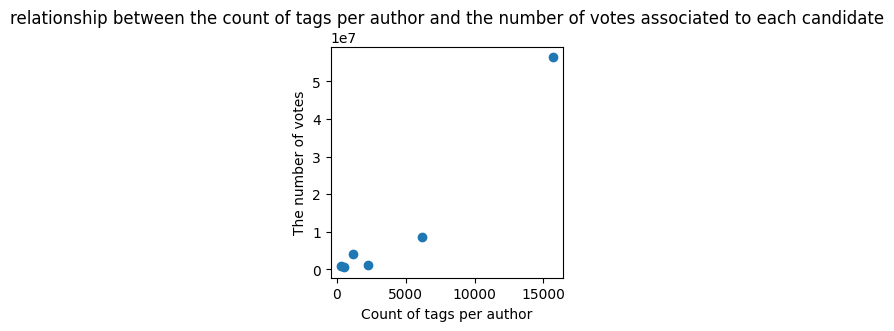

In [25]:
import matplotlib.pyplot as plt
import numpy as np

votes_count_col = votes_count.collect()
x = [vote.nb_authors for vote in votes_count_col]
y = [vote.votes for vote in votes_count_col]

# Calcul de la corrélation entre x et y
correlation = np.corrcoef(x, y)[0, 1]
print("Correlation between count of tags per author et the number of votes :", correlation)

plt.figure(figsize=(3, 3))
plt.scatter(x, y)
plt.xlabel("Count of tags per author") # and the number of votes associated
plt.ylabel("The number of votes")
plt.title("relationship between the count of tags per author and the number of votes associated to each candidate")

# Affichez le graphique
plt.show()

Nous observons une très forte correlation (0.968167171263933) entre le nombre de tag per authors et le nombre de votes pour chaque candidat.

### Window function

Read about the windowing functions https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html.

In [26]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank


Define a window specification for the `votes` and `nb_authors` columns

In [34]:
windowSpecVotes = Window.orderBy(desc(votes_count["votes"]))
windowSpecCount = Window.orderBy(desc(votes_count["nb_authors"]))


Using the window specifications, augment `votes_count` with two attributes, `votes_rank` and `nbAuths_ranks`, which rank each candidate  based on the number of votes he received  and the number of authors who tagged a post with his name.

Hint. The window spans the entire data and does not use any partitioning.

In [35]:
compare = votes_count\
        .withColumn("votes_rank", rank().over(windowSpecVotes))\
        .withColumn("nb_authors_rank", rank().over(windowSpecCount))\

compare.show()


+-----------+--------+----------+----------+---------------+
|       name|   votes|nb_authors|votes_rank|nb_authors_rank|
+-----------+--------+----------+----------+---------------+
|      putin|56430712|     15673|         1|              1|
|   grudinin| 8659206|      6207|         2|              2|
|    sobchak| 1238031|      2288|         4|              3|
|zhirinovsky| 4154985|      1214|         3|              4|
|      titov|  556801|       572|         6|              5|
|  yavlinsky|  769644|       347|         5|              6|
+-----------+--------+----------+----------+---------------+



### Multidimensional aggregation

We want to create a cube with three dimensions: `tag`, `event_type` and `month`. While the first two attributes are already available, the month column must be extracted from the `creation_time` attribute using a built-in function.

Create a dataset `dataTagMon` obtained by augmenting `data_with_tags` with an attribute `month` containing the month extracted from the `event.creation_time` attribute.

Hint. You will notice that only months 1, 2 and 3 exist in the dataset.

In [37]:
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import month

In [46]:
data_tag_mon = data_with_tags\
        .withColumn("month", month(from_unixtime(data_with_tags["event.creation_time"])))

data_tag_mon.select("month").distinct().show()

+-----+
|month|
+-----+
|    1|
|    3|
|    2|
+-----+



#### For each combination of event_type, tag and month, count the nomber of distinct post_ids

In [53]:
tag_event_month = data_tag_mon.groupBy("event.event_type","tag","month")\
  .agg(countDistinct("event.event_id.post_id").alias("count_dist_postids"))

tag_event_month.orderBy(desc("count_dist_postids")).show()

+----------+--------+-----+------------------+
|event_type|     tag|month|count_dist_postids|
+----------+--------+-----+------------------+
|   comment|   putin|    2|              4191|
|   comment|   putin|    3|              3543|
|      post|   putin|    2|              2963|
|      post|   putin|    3|              2954|
|   comment|grudinin|    2|              2012|
|   comment|grudinin|    3|              1484|
|      post|grudinin|    2|              1409|
|   comment|   putin|    1|              1390|
|      post|grudinin|    3|              1206|
|      post|   putin|    1|              1104|
|   comment| navalny|    2|               780|
|   comment| sobchak|    3|               538|
|      post| sobchak|    2|               503|
|   comment| navalny|    1|               474|
|      post| navalny|    2|               461|
|   comment|grudinin|    1|               442|
|   comment| sobchak|    2|               436|
|      post| sobchak|    3|               425|
|   comment| 

### Pivot table

#### Using the `tag_event_month` table, create a pivot table by reducing the dimensions to month and event type.

In [57]:
month_event_type = tag_event_month.groupBy('month')\
  .pivot('event_type').count()
month_event_type.printSchema()
month_event_type.show()

root
 |-- month: integer (nullable = true)
 |-- comment: long (nullable = true)
 |-- post: long (nullable = true)
 |-- share: long (nullable = true)

+-----+-------+----+-----+
|month|comment|post|share|
+-----+-------+----+-----+
|    1|      7|   7|    5|
|    3|      7|   7|    7|
|    2|      7|   7|    7|
+-----+-------+----+-----+



In [ ]:
month_event_type = tag_event_month.#complete
month_event_type.printSchema()
month_event_type.show()

root
 |-- month: integer (nullable = true)
 |-- comment: long (nullable = true)
 |-- post: long (nullable = true)
 |-- share: long (nullable = true)

+-----+-------+----+-----+
|month|comment|post|share|
+-----+-------+----+-----+
|    1|   2564|1986|  100|
|    3|   6424|5328|  207|
|    2|   7873|5863|  372|
+-----+-------+----+-----+



###  Tag co-occurrence matrix

#### create a dataframe indicating for each pair of distinct tags the author that uses both of them.

In [14]:
from pyspark.sql.functions import col

auth_tag = data_with_tags.select("event.author.id",'tag')

tag_co_occur = auth_tag.alias("a").join(auth_tag.alias("b"),
                                                (col("a.id") == col("b.id")) & (col("a.tag") != col("b.tag")),
                                                "inner")\
    .select(col("a.id").alias("authorID"), col("a.tag").alias("otherTag"), col("b.tag").alias("tag"))


tag_co_occur.show()

+---------+-----------+-----------+
| authorID|   otherTag|        tag|
+---------+-----------+-----------+
|  2000511|      putin|  yavlinsky|
|  2000511|  yavlinsky|      putin|
|121013525|      putin|   grudinin|
|121013525|      putin|    navalny|
|121013525|      putin|   grudinin|
|121013525|      putin|   grudinin|
|121013525|      putin|   grudinin|
|121013525|      putin|   grudinin|
| 67260949|      putin|    navalny|
|469347470|   grudinin|      putin|
|468277944|   grudinin|zhirinovsky|
| 54818744|   grudinin|    navalny|
| 54818744|   grudinin|zhirinovsky|
| 54818744|zhirinovsky|    navalny|
| 54818744|zhirinovsky|   grudinin|
| 54818744|zhirinovsky|   grudinin|
|329909622|   grudinin|      putin|
|329909622|   grudinin|    navalny|
|329909622|    navalny|      putin|
|329909622|    navalny|   grudinin|
+---------+-----------+-----------+
only showing top 20 rows



#### Build the tag co-occurence matrix indicating for each pair of tags the number of authors that use them

In [15]:
co_occur_mat = tag_co_occur.groupBy('tag').pivot('otherTag').count()

co_occur_mat.show()

+-----------+--------+-------+-----+-------+-----+---------+-----------+
|        tag|grudinin|navalny|putin|sobchak|titov|yavlinsky|zhirinovsky|
+-----------+--------+-------+-----+-------+-----+---------+-----------+
|  yavlinsky|     210|     60|  355|    199|   94|     null|        145|
|   grudinin|    null|   1113| 7267|    722|  140|      210|        714|
|      titov|     140|     21|  246|    111| null|       94|         90|
|    navalny|    1113|   null| 1806|    300|   21|       60|         90|
|    sobchak|     722|    300| 1299|   null|  111|      199|        439|
|zhirinovsky|     714|     90|  901|    439|   90|      145|       null|
|      putin|    7267|   1806| null|   1299|  246|      355|        901|
+-----------+--------+-------+-----+-------+-----+---------+-----------+



## END